#### Copyright 2017 Google LLC.

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Lab 3: Using Multiple Numerical Features and Feature Scaling 


**Learning Objectives:**
* Train a model using more than one feature
* Learn the importance of feature transformations
* Introduce linear and log transformations of features.


### Standard Set-up

We begin with the standard set-up as seen in the last lab.  We will again use the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile) and replace missing numerical values by the column mean.

In [0]:
import fnmatch
import math

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn import metrics
import tensorflow as tf
from tensorflow.contrib.learn.python.learn import learn_io, estimator

# This line increases the amount of logging when there is an error.  You can
# remove it if you want less logging.
tf.logging.set_verbosity(tf.logging.ERROR)

# Set the output display to have two digits for decimal places, for display
# readability only, and limit it to printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

# Provide the names for the columns since the CSV file with the data does
# not have a header row.
cols = ['symboling', 'losses', 'make', 'fuel-type', 'aspiration', 'num-doors',
        'body-style', 'drive-wheels', 'engine-location', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-type', 'num-cylinders',
        'engine-size', 'fuel-system', 'bore', 'stroke', 'compression-ratio',
        'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price']


# Load in the data from a CSV file that is comma seperated.
car_data = pd.read_csv('https://storage.googleapis.com/ml_universities/cars_dataset/cars_data.csv',
                        sep=',', names=cols, header=None, encoding='latin-1')

# We randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of stochastic gradient
# descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

# Coerce all missing entries to NaN, and then replace those by the column mean.
car_data['price'] = pd.to_numeric(car_data['price'], errors='coerce')
car_data['horsepower'] = pd.to_numeric(car_data['horsepower'], errors='coerce')
car_data['peak-rpm'] = pd.to_numeric(car_data['peak-rpm'], errors='coerce')
car_data['city-mpg'] = pd.to_numeric(car_data['city-mpg'], errors='coerce')
car_data['highway-mpg'] = pd.to_numeric(car_data['highway-mpg'], errors='coerce')
car_data.fillna(car_data.mean(), inplace=True)
car_data.describe()

,symboling,wheel-base,length,width,height,weight,engine-size,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00,205.00
mean,0.83,98.76,174.05,65.91,53.72,2555.57,126.91,10.14,104.26,5125.37,25.22,30.75,13207.13
std,1.25,6.02,12.34,2.15,2.44,520.68,41.64,3.97,39.52,476.98,6.54,6.89,7868.77
min,-2.00,86.60,141.10,60.30,47.80,1488.00,61.00,7.00,48.00,4150.00,13.00,16.00,5118.00
25%,0.00,94.50,166.30,64.10,52.00,2145.00,97.00,8.60,70.00,4800.00,19.00,25.00,7788.00
50%,1.00,97.00,173.20,65.50,54.10,2414.00,120.00,9.00,95.00,5200.00,24.00,30.00,10595.00
75%,2.00,102.40,183.10,66.90,55.50,2935.00,141.00,9.40,116.00,5500.00,30.00,34.00,16500.00
max,3.00,120.90,208.10,72.30,59.80,4066.00,326.00,23.00,288.00,6600.00,49.00,54.00,45400.00


### Setting Up the Feature Columns and Input Function for TensorFlow
In order to train a model in TensorFlow, each feature that you want to use for training must be put into a feature column.  We create a list of the categorical and numerical features that we will use for training our model. It's okay if one of these lists is empty. We also define `train_input_fn` to use the training data.

In [0]:
CATEGORICAL_COLUMNS = []
NUMERICAL_COLUMNS = ["price", "horsepower", "city-mpg", "highway-mpg",
                     "peak-rpm", "compression-ratio"]

def input_fn(dataframe):
  """Constructs a dictionary for the feature columns.

  Args:
    dataframe: The Pandas DataFrame to use for the input.
  Returns:
    The feature columns and the associated labels for the provided input.
  """
  # Creates a dictionary mapping from each numeric feature column name (k) to
  # the values of that column stored in a constant Tensor.
  numerical_cols = {k: tf.constant(dataframe[k].values)
                     for k in NUMERICAL_COLUMNS}
  # Creates a dictionary mapping from each categorical feature column name (k)
  # to the values of that column stored in a tf.SparseTensor.
  categorical_cols = {k: tf.SparseTensor(
      indices=[[i, 0] for i in range(dataframe[k].size)],
      values=dataframe[k].values,
      dense_shape=[dataframe[k].size, 1])
                      for k in CATEGORICAL_COLUMNS}
  # Merges the two dictionaries into one.
  feature_cols = dict(numerical_cols.items() + categorical_cols.items())
  # Converts the label column into a constant Tensor.
  label = tf.constant(dataframe[LABEL].values)
  # Returns the feature columns and the label.
  return feature_cols, label

def train_input_fn():
  """Sets up the input function using the training data.

  Returns:
     The feature columns to use for training and the associated labels.
  """
  return input_fn(training_examples)

### Defining the features and linear regression model

We define a function to construct the feature columns, and to define the TensorFlow linear regression model.

In [0]:
def construct_feature_columns():
  """Construct TensorFlow Feature Columns.
  
  Returns:
    A set of feature columns.
  """
  feature_set = set([tf.contrib.layers.real_valued_column(feature) 
                     for feature in NUMERICAL_FEATURES])
  return feature_set

def define_linear_regression_model(learning_rate):
  """ Defines a linear regression model of one feature to predict the target.
  
  Args:
    learning_rate: A `float`, the learning rate
    
  Returns:
    A linear regressor created with the given parameters
  """
  linear_regressor = tf.contrib.learn.LinearRegressor(
    feature_columns=construct_feature_columns(),
    optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate),
    gradient_clip_norm=5.0
  )  
  return linear_regressor

### Methods to visualize our results

We define functions to draw a scatter plot (with model names shown in a legend), create a calibration plot, and also to plot the learning curve.

In [0]:
def make_scatter_plot(dataframe, input_feature, target,
                      slopes=[], biases=[], model_names=[]):
  """ Creates a scatter plot of input_feature vs target along with model names.
  
  Args:
    dataframe: the dataframe to visualize
    input_feature: the input feature to be used for the x-axis
    target: the target to be used for the y-axis
    slopes: list of model weights (slope) 
    bias: list of model biases (same length as slopes)
    model_names: list of model_names to use for legend (same length as slopes)
  """      
  # Define some colors to use that go from blue towards red
  colors = [cm.coolwarm(x) for x in np.linspace(0, 1, len(slopes))]
  
  # Generate the scatter plot
  x = dataframe[input_feature]
  y = dataframe[target]
  plt.ylabel(target)
  plt.xlabel(input_feature)
  plt.scatter(x, y, color='black', label="")

  # Add lines corresponding to the provided models
  for i in range (0, len(slopes)):
    y_0 = slopes[i] * x.min() + biases[i]
    y_1 = slopes[i] * x.max() + biases[i]
    plt.plot([x.min(), x.max()], [y_0, y_1],
             label=model_names[i], color=colors[i])
  plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
  
def make_calibration_plot(predictions, targets):
  """ Creates a calibration plot.
  
  Args:
    predictions: a list of values predicted by the model being visualized
    targets: a list of the target values being predicted that must be the
             same length as predictions.
  """  
  calibration_data = pd.DataFrame()
  calibration_data["predictions"] = pd.Series(predictions)
  calibration_data["targets"] = pd.Series(targets)
  calibration_data.describe()
  min_val = calibration_data["predictions"].min()
  max_val = calibration_data["predictions"].max()
  plt.ylabel("target")
  plt.xlabel("prediction")
  plt.scatter(predictions, targets, color='black')
  plt.plot([min_val, max_val], [min_val, max_val])
  
def plot_learning_curve(training_losses):
  """ Plot the learning curve.
  
  Args:
    training_loses: a list of losses to plot.
  """        
  plt.ylabel('Loss')
  plt.xlabel('Training Steps')
  plt.plot(training_losses)

### Functions for training the model

We use the same method as in the last lab to define the loss function (RMSE for linear regression) and to train the model.

In [0]:
def compute_loss(predictions, targets):
  """ Computes the loss (RMSE) for linear regression.
  
  Args:
    predictions: a list of values predicted by the model.
    targets: a list of the target values being predicted that must be the
             same length as predictions.
    
  Returns:
    The RMSE for the provided predictions and targets.
  """      
  return math.sqrt(metrics.mean_squared_error(predictions, targets))

def train_model(linear_regressor, steps):
  """Trains a linear regression model.
  
  Args:
    linear_regressor: The regressor to train.
    steps: A positive `int`, the total number of training steps.
    
  Returns:
    The trained regressor.
  """
  # In order to see how the model evolves as we train it, we divide the
  # steps into ten periods, and show the model after each period.
  periods = 10
  steps_per_period = steps / periods
  
  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics. We store the loss, slope (feature weight), bias, and a name
  # for the model when there is a single feature (which would then allow us
  # to plot the model in a scatter plot).
  print "Training model..."
  training_losses = []
  slopes = []
  biases = []
  model_names = []

  for period in range (0, periods):
    # Call fit to train the regressor for steps_per_period steps
    linear_regressor.fit(input_fn=train_input_fn, steps=steps_per_period)

    # Use the predict method to compute the predictions of the current model
    predictions = np.array(list(linear_regressor.predict(
        input_fn=train_input_fn)))
   
    # Compute the loss between the predictions and correct labels, append
    # the loss to the list of losses used to generate the learning curve after
    # training is complete, and print the current loss
    loss = compute_loss(predictions, training_examples[LABEL])
    training_losses.append(loss) 
    print "  Loss after period %02d : %0.3f" % (period, loss)
     
    # When there is a single input feature, add slope, bias and model_name to
    # the lists to be used later to plot the model.
    if len(NUMERICAL_FEATURES) == 1 and len(CATEGORICAL_FEATURES) == 0:
      feature_weight = fnmatch.filter(linear_regressor.get_variable_names(),
                                      'linear/*/weight')
      slopes.append(linear_regressor.get_variable_value(
          feature_weight[0])[0])
      biases.append(linear_regressor.get_variable_value(
          'linear/bias_weight')[0])
      model_names.append("period_" + str(period))
      
  # Now that training is done print the final loss    
  print "Final Loss (RMSE) on the training data: %0.3f" % loss 
  
  # Generate a figure with the learning curve on the left and either a scatter
  # plot or calibration plot (when more than 2 input features) on the right.
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.title("Learning Curve (RMSE vs time)")
  plot_learning_curve(training_losses)
  plt.subplot(1, 2, 2)
  plt.tight_layout(pad=1.1, w_pad=3.0, h_pad=3.0)
 
  if len(NUMERICAL_FEATURES) > 1 or len(CATEGORICAL_FEATURES) != 0:
    plt.title("Calibration Plot")
    make_calibration_plot(predictions, training_examples[LABEL])

  else:
    plt.title("Learned Model by Period on Scatter Plot")
    make_scatter_plot(training_examples, NUMERICAL_FEATURES[0], LABEL,
                      slopes, biases, model_names)
   
  return linear_regressor

###Prepare Features

In this lab you'll learn about the need to perform some feature transformation.  You'll do this by modifyijng the processed features before returning them.  So expect to modify this function later in this lab.

In [0]:
def prepare_features(dataframe):
  """Prepares the features for the provided dataset.

  Args:
    dataframe: A Pandas DataFrame that contains the data set.
  Returns:
    A new DataFrame that contains the features to be used to train the model.
  """
  processed_features = dataframe.copy()
  return processed_features

### Generate the Training Examples
We simple call `prepare_features` on the `car_data` dataframe.  We also include code to plot a histogram of `price`, `highway-mpg` and `city-mpg` to help understand the data we are using to train our model to predict `city-mpg`.

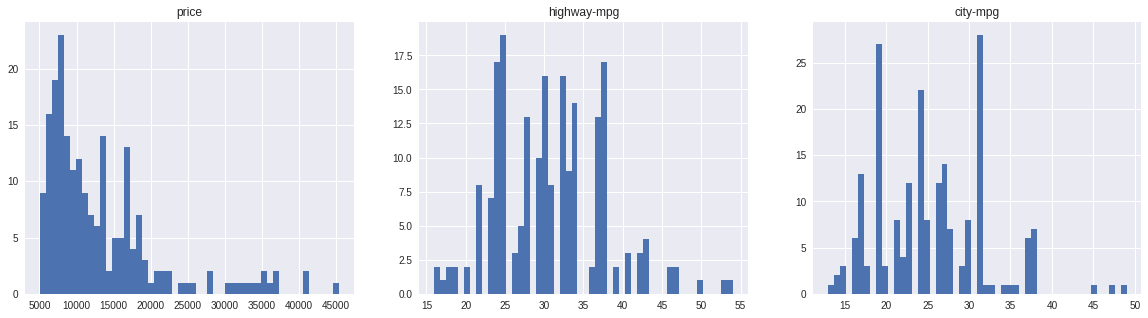

In [0]:
training_examples = prepare_features(car_data)

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.title("price")
histogram = car_data["price"].hist(bins=50)

plt.subplot(1, 3, 2)
plt.title("highway-mpg")
histogram = car_data["highway-mpg"].hist(bins=50)


plt.subplot(1, 3, 3)
plt.title("city-mpg")
histogram = car_data["city-mpg"].hist(bins=50)

##Task 1: Train a Model Using Two Input Features (2 points)

The focus on this lab is learning some of the issues that arise,  and how to address them when you train a model with multiple features.  The first task is to train a model to predict `city-mpg` from `highway-mpg` and `price` without using any feature processing.  Remember what you learned in the last lab about how to find a good learning rate and numer of steps to train.

Training model...
  Loss after period 00 : 24.715
  Loss after period 01 : 23.962
  Loss after period 02 : 23.419
  Loss after period 03 : 23.042
  Loss after period 04 : 22.743
  Loss after period 05 : 22.570
  Loss after period 06 : 22.467
  Loss after period 07 : 22.405
  Loss after period 08 : 22.370
  Loss after period 09 : 22.350
Final Loss (RMSE) on the training data: 22.350
weight for price: [-0.00141656]
weight for highway-mpg: [0.7887362]
bias: [0.0188171]


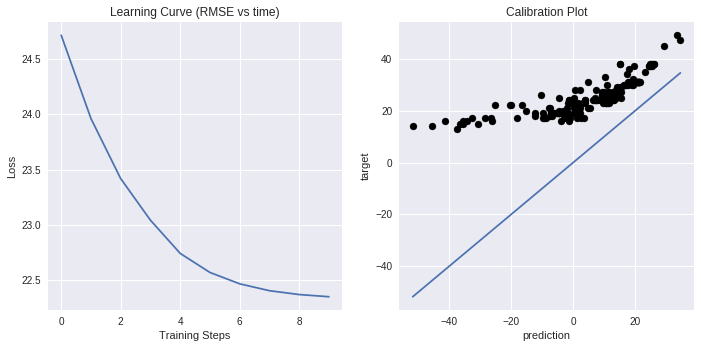

In [0]:
NUMERICAL_FEATURES = ["price", "highway-mpg"]
CATEGORICAL_FEATURES = []
LABEL = "city-mpg"

LEARNING_RATE = .125
STEPS = 7000

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(linear_regressor, steps=STEPS)

print "weight for price:", linear_regressor.get_variable_value(
    "linear/price/weight")[0]
print "weight for highway-mpg:", linear_regressor.get_variable_value(
    "linear/highway-mpg/weight")[0]
print "bias:",  linear_regressor.get_variable_value("linear/bias_weight")

### Think about these questions about what you found in training your model in Task 1

* Look at the weight for the two variables.  Do they match what you'd expect to see?
* Given that `highway-mpg` is well correlated with `city-mpg`, what is it you see in the histograms that might explain why it was hard to train the model?
* For linear regression it is important that all of the features are roughly in the same range so that a priori they are treated as equally important.  How does the range of the price compare to the highway mpg, and what effect might this have when training the model?


## Task 2: Write a Linear Scaling Function (1 point)

There are two characteristics we'd like of numerical features when used together to train a linear model
* The range of the features is roughly the same
* To the extent possible the histogram of the features kind of resembles a bell curve.  Sometimes the data will fit this very well and other times it won't.

As you've already seen in the code, you can take a Pandas column (e.g. `car_data['price']`) and find the min value with `car_data['price'].min()` and likewise find the max with `car_data['price'].max()`. Note that you can use a lambda function to apply `f(x)` to all entries `x` in a Pandas column `feature` using.
```
   feature.apply(lambda x: f(x))
```

To provide an example of feature transformation, we have provided an implementation for log scaling.  Note that we take the log of x+1 for column value of x so that we are always taking the log of a number greater than 0 since log 0 is not defined. In this data all values are at least 0, so log(x+1) is well defined.

You are to complete the implementation of `linear_scale`, in which you simply stretch/compress and shift the features linearly to fall into the interval [0,1]. The minimum value that occurs will map to 0, the maximum value that occurs will map to 1, (min + max)/2 will map to 0.5, and so on.  You will need to make sure that your output from `linear_scale` is a real number (versus an integer). Be sure to test your function on some examples.  For example if the input series originally had values going from 10 to 20, then after applying linear scale 10 should map to 0, 11 should map to 1, 12 should map to 2, ... and so on with 20 mapping to 1.

In [0]:
# Perform log scaling
def log_scale(series):
  return series.apply(lambda x:math.log(x+1.0))

# Linearly rescales to the range [0, 1]
# You need to write this function.  Right now it just returns the same series.
def linear_scale(series):
  # add any additional lines of code needed
  min_value = series.min()
  max_value = series.max()
  return series.apply(lambda x: (x-min_value)/(max_value-min_value))

**Test your scaling procedure** with the following code block that applies these two scaling methods to `price` and `highway-mpg` and then draws a histogram for each.

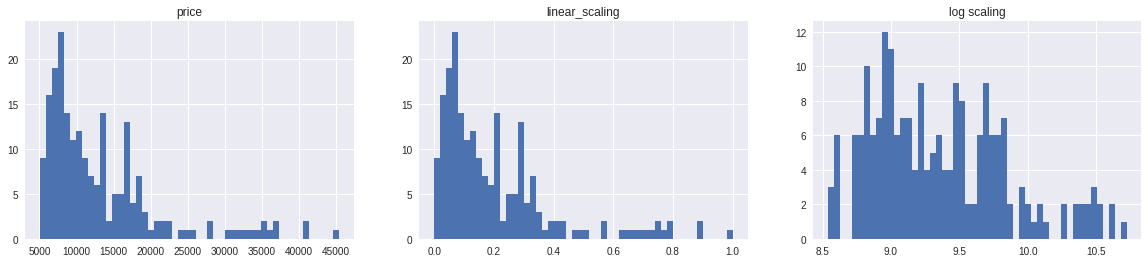

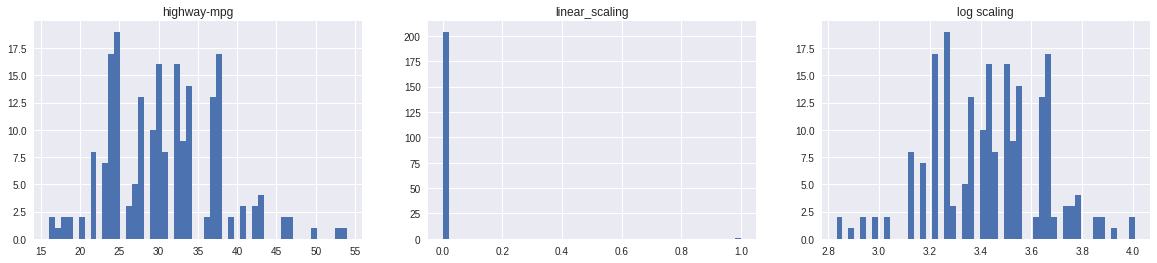

In [0]:
def draw_histograms(feature_name):
  plt.figure(figsize=(20, 4))
  plt.subplot(1, 3, 1)
  plt.title(feature_name)
  histogram = car_data[feature_name].hist(bins=50)

  plt.subplot(1, 3, 2)
  plt.title("linear_scaling")
  scaled_features = pd.DataFrame()
  scaled_features[feature_name] = linear_scale(car_data[feature_name])
  histogram = scaled_features[feature_name].hist(bins=50)
  
  plt.subplot(1, 3, 3)
  plt.title("log scaling")
  log_normalized_features = pd.DataFrame()
  log_normalized_features[feature_name] = log_scale(car_data[feature_name])
  histogram = log_normalized_features[feature_name].hist(bins=50)
  
draw_histograms('price')
draw_histograms("highway-mpg")

##Task 3 - Training the Model Using the Transformed Features (2 points)

Modify `prepare_features` to apply linear scaling to `price` and `highway-mpg` and then train the best model you can. **Do not modify the target feature so that the RMSE can be compared to the model you trained in Task 2 and also you want your predictions to be in the correct range**.

NOTE: It is possible that if your learning rate is too high you will converge to a solution that is not optimal since you are overshotting and then undershooting the best feature weights as you get close to the optimal solution.  So when looking at the scatter plot, if you converge to a model that is not good, try a slightly smaller learning rate.



In [0]:
def prepare_features(dataframe):
  """Prepares the features for provided dataset.

  Args:
    dataframe: A Pandas DataFrame expected to contain data from the
      desired data set.
  Returns:
    A new dataFrame that contains the features to be used for the model.
  """
  processed_features = dataframe.copy()

  # Apply linear scaling to price and highway-mpg here
  processed_features['price'] = linear_scale(processed_features['price'])
  processed_features['highway-mpg'] = linear_scale(processed_features['highway-mpg'])
  
  return processed_features

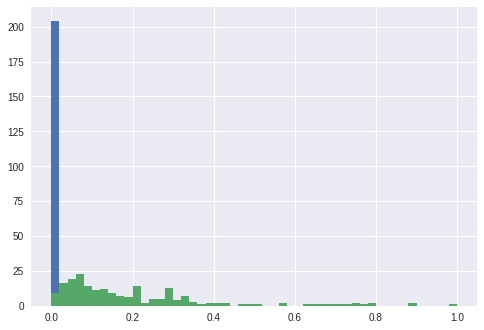

In [0]:
training_examples = prepare_features(car_data)

histogram = training_examples["highway-mpg"].hist(bins=50)
histogram = training_examples["price"].hist(bins=50)

Training model...
  Loss after period 00 : 4.958
  Loss after period 01 : 4.744
  Loss after period 02 : 4.708
  Loss after period 03 : 4.688
  Loss after period 04 : 4.675
  Loss after period 05 : 4.667
  Loss after period 06 : 4.662
  Loss after period 07 : 4.658
  Loss after period 08 : 4.656
  Loss after period 09 : 4.655
Final Loss (RMSE) on the training data: 4.655
['global_step', 'linear/bias_weight', 'linear/highway-mpg/weight', 'linear/price/weight']
weight for price: [-21.975756]
weight for highway-mpg: [17.957867]
bias: [29.545029]


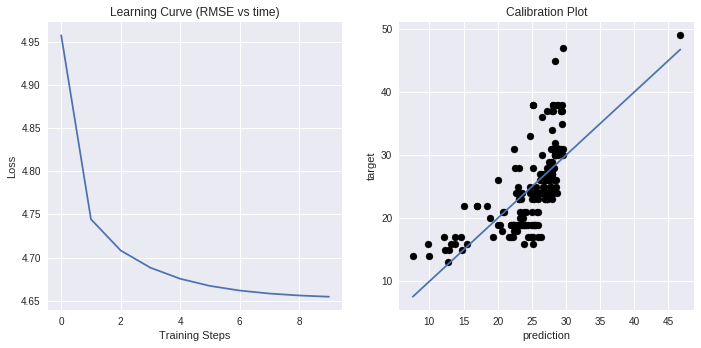

In [0]:
NUMERICAL_FEATURES = ["price", "highway-mpg"]
CATEGORICAL_FEATURES = []
LABEL = "city-mpg"

LEARNING_RATE = .75
STEPS = 300

linear_regressor = define_linear_regression_model(learning_rate = LEARNING_RATE)
linear_regressor = train_model(linear_regressor, steps=STEPS)

# Let's also look at the weights and bias
print linear_regressor.get_variable_names()
print "weight for price:", linear_regressor.get_variable_value(
    "linear/price/weight")[0]
print "weight for highway-mpg:", linear_regressor.get_variable_value(
    "linear/highway-mpg/weight")[0]
print "bias:",  linear_regressor.get_variable_value("linear/bias_weight")

You are welcome to also explore using other feature transformations such as log scaling or linear scaling applied after log scaling.  However, for this simple problem, linear scaling is sufficient.